# Loading and Investigating Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
'''
import kaggle

Terminal commands to download

kaggle competitions download -c dog-breed-identification
unzip /content/dog-breed-identification.zip
'''

Constants

In [2]:
DATA_ROOT = "/content/" #should have training folder and csv
BATCH_SIZE = 128
IMG_SIZE = [224, 224] 

### Data Investigation and label creation

In [ ]:
train_dir = DATA_ROOT + 'train\\'

# Reading csv
labels = pd.read_csv(DATA_ROOT + 'labels.csv')
print(labels.head) 

# Creating array of image paths
img_paths = []
for id in labels['id']:
    img_paths.append(train_dir + id + ".jpg")
    
print(img_paths[:5])

In [4]:
# Creating integer classes
le = LabelEncoder()
int_input = le.fit_transform(labels.iloc[:,1].values)
labels['int_class'] = int_input

labels[:10]

,id,breed,int_class
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,10
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,10
7,002a283a315af96eaea0e28e7163b21b,borzoi,18
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,97


In [5]:
# Creating one hot encoded labels
cat_count = 120  #depth or the number of categories
oh_input = tf.one_hot(int_input, cat_count) #apply one-hot encoding 
print(oh_input[0].numpy())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Data Pipeline

Some Notes:  
    -ImageDataGenerator is deprecated and does not utilize tf.data  
    -can use tf.keras.preprocessing.image_dataset_from_directory IF classes are separated by subfolders  
    -use tfRecords for optimal efficiency  

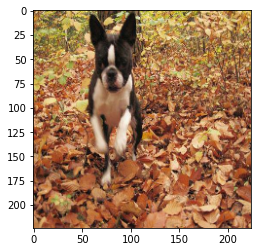

****Image:  [0.5705322  0.33588538 0.15008473]
****Label:  19


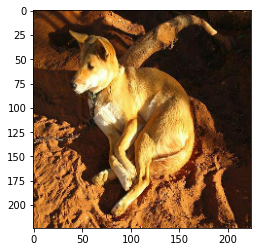

****Image:  [0.22176053 0.1532646  0.12077089]
****Label:  37


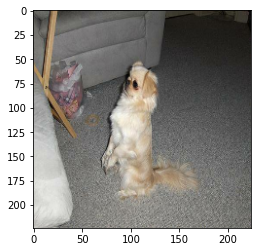

****Image:  [0.3918853  0.3918853  0.36051273]
****Label:  85


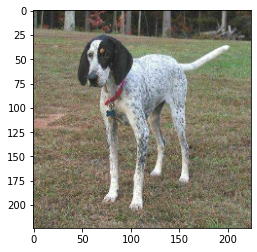

****Image:  [0.30236846 0.29130402 0.27799872]
****Label:  15


' Alternative Method\ndef read_and_decode(filename):\n    # Returns a tensor with byte values of the entire contents of the input filename.\n    img = tf.io.read_file(filename)\n    # Decoding raw JPEG tensor data into 3D (RGB) uint8 pixel value tensor\n    img = tf.io.decode_jpeg(img, channels=3)\n    # Converting from uint8 [0,256] pixel values to float32 [0, 1] pixel values\n    img = tf.image.convert_image_dtype(img, tf.float32)\n    # Resize for various architectures\n    img = tf.image.resize(img, [128, 128])\n    \n    return img\n\n# Using function above to map image file paths to normalized RGB pixel values\nimgs_ds = tf.data.Dataset.list_files(train_dir + \'*\', shuffle=False)\nimgs_ds = imgs_ds.map(read_and_decode)\n\n# Creating two labels datasets, one-hot and integer labels. Will see which one performs best.\nlabels_oh = tf.data.Dataset.from_tensor_slices(oh_input)\nlabels_int = tf.data.Dataset.from_tensor_slices(int_input)\n\n# Combining image ds and label ds into one (fo

In [6]:
def read_and_decode2(filename, label):
    # Returns a tensor with byte values of the entire contents of the input filename.
    img = tf.io.read_file(filename)
    # Decoding raw JPEG tensor data into 3D (RGB) uint8 pixel value tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Converting from uint8 [0,256] pixel values to float32 [0, 1] pixel values
    # (Do not need this due to the preprocess_input function below)
    #img = tf.image.convert_image_dtype(img, tf.float32)
    #Resize
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img, label

ds_oh = tf.data.Dataset.from_tensor_slices((img_paths, oh_input))
ds_oh = ds_oh.map(read_and_decode2)

# Visualizing dataset
for image, label in ds_oh.take(4):
    plt.imshow(image.numpy())
    plt.show()
    print("****Image: ",image.numpy()[0][0])
    print("****Label: ",label.numpy())


''' Alternative Method
def read_and_decode(filename):
    # Returns a tensor with byte values of the entire contents of the input filename.
    img = tf.io.read_file(filename)
    # Decoding raw JPEG tensor data into 3D (RGB) uint8 pixel value tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Converting from uint8 [0,256] pixel values to float32 [0, 1] pixel values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize for various architectures
    img = tf.image.resize(img, [128, 128])
    
    return img

# Using function above to map image file paths to normalized RGB pixel values
imgs_ds = tf.data.Dataset.list_files('C:/Users/jgett/OneDrive/Desktop/AI/Projects/Kaggle/Data/dogs/train/*', shuffle=False)
imgs_ds = imgs_ds.map(read_and_decode)

# Creating two labels datasets, one-hot and integer labels. Will see which one performs best.
labels_oh = tf.data.Dataset.from_tensor_slices(oh_input)
labels_int = tf.data.Dataset.from_tensor_slices(int_input)

# Combining image ds and label ds into one (for both one-hot and int labels)
ds_oh = tf.data.Dataset.zip((imgs_ds, labels_oh))
ds_int = tf.data.Dataset.zip((imgs_ds, labels_int))

# Visualizing dataset
for image, label in ds_int.take(3):
    plt.imshow(image.numpy())
    plt.show()
    print("****Image: ",image.numpy()[0][0])
    print("****Label: ",label.numpy())
'''

Dataset Train and  Validation Split

In [7]:
def ds_split(ds, ds_size, shuffle_size, train_split=0.8, val_split=0.2, shuffle=True):
    assert (train_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=99)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

In [8]:
train_ds, val_ds = ds_split(ds_oh, len(img_paths), len(img_paths), train_split=0.8, val_split=0.2, shuffle=True)

### Dataset Optimization

- The order of all these commands absolutely matter, and it is worth experiementing with different orders of operation.  
- See (https://cs230.stanford.edu/blog/datapipeline/#best-practices), (https://www.tensorflow.org/guide/data_performance#best_practice_summary), (https://stackoverflow.com/questions/50437234/tensorflow-dataset-shuffle-then-batch-or-batch-then-shuffle)  
- .cache() will put all data into memory. Everything before caching will be unalterable. Everything after caching will be run each epoch.  
- Shuffling data between epochs is good practice, and you will want to shuffle before creating batches.  
- You do not need to specify batch size in model.fit if you are using tf.data.  
- Prefetch will prepare data in parallel with the model training, it is almost always good practice to use it.



In [9]:
#One hot
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(buffer_size=len(img_paths), reshuffle_each_iteration=True)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

'\ntrain_ds_int = train_ds_int.cache()\ntrain_ds_int = train_ds_int.shuffle(buffer_size=len(img_paths), reshuffle_each_iteration=True)\ntrain_ds_int = train_ds_int.batch(64)\ntrain_ds_int = train_ds_int.prefetch(tf.data.AUTOTUNE)\n\nval_ds_int = val_ds_int.cache()\nval_ds_int = val_ds_int.batch(BATCH_SIZE)\nval_ds_int = val_ds_int.prefetch(tf.data.AUTOTUNE)\n'

# Model Building

In [10]:
import os
from os.path import join # operating system file paths
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting graphs

import tensorflow as tf
from tensorflow import keras
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint


from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

### Preprocessing layers

It's good practice to perform data augmentation in preprocessing layers so GPU may be utilized. (Alternative is to map tf.image functions during dataset creation. This would utilize CPU though)  
https://jonathan-hui.medium.com/tensorflow-keras-preprocessing-layers-dataset-performance-considera-e9fc11de7bc7  
https://www.tensorflow.org/guide/keras/preprocessing_layers


In [11]:
# Augmentation Layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ]
)

### Transfer Learning

In [12]:
# input layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# taking the popular ResNet model trained on imagenet, and excluding the top of the network.
# include_top=False exludes the last global pooling and fully connected prediciton layer
# so final layer is of size (7, 7, 2048)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))(x)

# creating our new model head to combine with the ResNet base model
head_model = MaxPool2D(pool_size=(4, 4))(base_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(120, activation='softmax')(head_model)

# final configuration
model = Model(inputs, head_model)

# RESNet model trainable = False
# freezing bottom layers so weights are not adjusted during training
# the feature extraction (conv, pooling) sections stay intact
model.layers[2].trainable = False

# Categorical crossentropy loss should be used when determining labels from many classes
#    and only if the output values are one hot encoded
# SGD or Adam optimizer is usually a good default choice as a general purpose optimizer 
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [ ]:
INITIAL_EPOCHS = 35

history = model.fit(train_ds,
                    epochs=INITIAL_EPOCHS,
                    validation_data=val_ds)

### Fine Tuning

**From TF Transfer Learning API:**  
"In the feature extraction experiment, you were only training a few layers on top of an (image classifier) base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning."

Unfreezing Layers

In [ ]:
model.layers[2].trainable = True
FINE_TUNE_EPOCHS = 40
total_epochs =  INITIAL_EPOCHS + FINE_TUNE_EPOCHS

checkpoint = ModelCheckpoint("dog_breeds.hdf5",monitor='val_loss',verbose=1,mode='min',save_best_only=True,save_weights_only=True)

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=[checkpoint],
                         validation_data=val_ds)

### Notes

1) On initial run, validation accuracy was very low (around 2%) and the same value for every epoch. Changed optimizer to SGD and received same results. Increased learning rate to 0.03, possible that model was getting stuck in local minima. No change, a little worse actually. Changed MaxPooling to AveragePooling. No Change, found local minima around 1% again. Change back to maxpool, changed SGD learning rate to 0.07. No change. Local minima at 1%. Changed to back Adam with lr=0.05. No change. Will double check model and data now.  
2) Looked over the train and val datasets in their final form. Images look correct and one-hot labels seem correct as well.  
3) Removed Shuffling. No change. Removed shuffling in train split. No change. Changed dropout to .1. Slight improvement but basically no change. Tried removing data augmentation layers. Removed data augmentation. Performed even worse at ~1%.
4) **SOLUTION** Tested accuracy of dataset on RESNET50 imagenet weights. Realized dataset was in wrong color channel order. Used RESNET50 preprocess function. Original RESNET50 model began classifying each image as dog breeds, but dog breeds were not correct most of the time. Seems like this is the problem. ~40% train and val accuracy.
6) Changed head model dense layer from 1024 to 512, SGD to 0.03. ~85% train and 67% val
7) I don't think head model has any effect. Adam optimizer does not work. SGD of lr 0.07 does not work. SGD of <0.03 is only thing that works
8) At SGD lr=0.02, epoch 24 val accuracy plateaus to 68%-69%. Train keeps increasing to final of 88% at epoch 35. Continuing training with lr=0.01 brings val to 75%.
9) Dropout of 0.2 hovers val acc around 69%. Dropout of 0.5, 0.4 has reduce acc to an unstable 68%. Dropout of 0.4, 0.3 is more unstable, hovers around 67%.
10) lr = 0.01 (and Dropout 0.2) is stable, but tops around 71%. lr=0.005 is same. lr=0.001 unstable around 67%
11) Removing 512 layer reduces to 67-68%. Removing 1024 stays around 69-70%
12) Averagepool instead of maxpool got 70-71% val
13) Changed all data augmentation to 0.2. No change.
14) Batch size of 64 (was 32) and test train split to 87% / 13%. Val acc around 70-71% loss is 1.05
15) Adam Optimizer lr=0.001 val acc 65%. SGD of 0.001 with momentum=0.9. Val acc consistent at 71-72%.
16) **SOLUTION** Achieved 93% val accuracy. Change test-train split to 80/20. Removed shuffling from tf.data. Added shuffling to dataset when splitting. Will run again to see which of these is the reason for the jump. Shuffling dataset before splitting (still 80/20 split, including shuffling in tf.data) brings val acc up to 85/86% but loss was still going down. Now going back to No Shuffle in tf.ds and shuffle before split, acc is still 85/86%. Cannot get back to 90%+. CONFIRMED data must be shuffled when splitting. I don't think shuffling in tf.data has any effect. How to get back to 93%??
17) Finetuning (setting RESNET layers to trainable) has gotten model to 90% after 55 epochs. Val loss started to increase after epoch 65. 91% val accuracy. 87% train accuracy.
18) Final configuration: ~85% val acc to 35 epochs. Set RESNET layers to trainable, finetune to 70 epochs. .345 val loss 91.1% accuracy. .382 train loss, 88% train accuracy.


Prediction: Must load weights before compiling

# **Predicting Test Images**

In [ ]:
model.load_weights('/content/dog_breeds.hdf5')
for layer in model.layers:
    layer.trainable = False

In [ ]:
def read_and_decode(filename):
    # Returns a tensor with byte values of the entire contents of the input filename.
    img = tf.io.read_file(filename)
    # Decoding raw JPEG tensor data into 3D (RGB) uint8 pixel value tensor
    img = tf.io.decode_jpeg(img, channels=3)
    #Resize
    img = tf.image.resize(img, IMG_SIZE)
    
    img = preprocess_input(img)
    return img

In [ ]:
img_paths = []
img_paths.append('/content/0d61e4885d53a0abad1112c4edfa9fda.jpg')
ds_test = tf.data.Dataset.from_tensor_slices((img_paths))
ds_test = ds_test.map(read_and_decode).batch(1)

In [ ]:
guess_label = tf.argmax(model.predict(ds_test), axis=-1).numpy()[0]
labels[labels['int_class']==guess_label].iloc[0]['breed']